# Welcome to Colab!

In [11]:
!pip install -q imbalanced-learn

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# ===============================
# 2. Load Dataset
# ===============================
df = pd.read_csv("hospital_readmission_final_realistic_data.csv")

print("Initial shape:", df.shape)
df.head()

Initial shape: (6000, 12)


,patient_name,age,gender,diagnosis_code,num_diagnoses,procedure,lab_result,length_of_stay,previous_admissions,discharge_disposition,readmission_label,risk_probability
0,Kavya Mehta,58,FEMALE,Z00,2,proc_b,94.058078,4.171972,1,Home,Not Readmitted,0.217
1,SWATHI MALHOTRA,57,Male,I10,1,PROC_A,NaN,7.515823,1,AMA,Not Readmitted,0.398
2,swathi chatterjee,76,FEMALE,J44,1,proc_b,NaN,6.800753,4,Home,Not Readmitted,0.416
3,NEHA CHATTERJEE,37,MALE,I10,1,proc_d,95.652343,3.949745,0,Home,Not Readmitted,0.106
4,sneha iyer,71,FEMALE,I10,0,NaN,NaN,4.941633,1,Home,Not Readmitted,0.225


In [12]:
# Numeric columns
df["lab_result"].fillna(df["lab_result"].median(), inplace=True)

# Text columns
df["procedure"].fillna("Unknown", inplace=True)
df.head()




/tmp/ipython-input-1140597709.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["lab_result"].fillna(df["lab_result"].median(), inplace=True)
/tmp/ipython-input-1140597709.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

,patient_name,age,gender,diagnosis_code,num_diagnoses,procedure,lab_result,length_of_stay,previous_admissions,discharge_disposition,readmission_label,risk_probability
0,Kavya Mehta,58,FEMALE,Z00,2,proc_b,94.058078,4.171972,1,Home,Not Readmitted,0.217
1,SWATHI MALHOTRA,57,Male,I10,1,PROC_A,96.256512,7.515823,1,AMA,Not Readmitted,0.398
2,swathi chatterjee,76,FEMALE,J44,1,proc_b,96.256512,6.800753,4,Home,Not Readmitted,0.416
3,NEHA CHATTERJEE,37,MALE,I10,1,proc_d,95.652343,3.949745,0,Home,Not Readmitted,0.106
4,sneha iyer,71,FEMALE,I10,0,Unknown,96.256512,4.941633,1,Home,Not Readmitted,0.225


In [13]:
text_cols = df.select_dtypes(include=["object"]).columns

for col in text_cols:
    df[col] = df[col].str.lower()

In [14]:
df["length_of_stay"] = df["length_of_stay"].round().astype(int)

In [15]:
df.head()

,patient_name,age,gender,diagnosis_code,num_diagnoses,procedure,lab_result,length_of_stay,previous_admissions,discharge_disposition,readmission_label,risk_probability
0,kavya mehta,58,female,z00,2,proc_b,94.058078,4,1,home,not readmitted,0.217
1,swathi malhotra,57,male,i10,1,proc_a,96.256512,8,1,ama,not readmitted,0.398
2,swathi chatterjee,76,female,j44,1,proc_b,96.256512,7,4,home,not readmitted,0.416
3,neha chatterjee,37,male,i10,1,proc_d,95.652343,4,0,home,not readmitted,0.106
4,sneha iyer,71,female,i10,0,unknown,96.256512,5,1,home,not readmitted,0.225


In [16]:
df["readmission_label"] = (
    df["readmission_label"]
    .astype(str)          # convert mixed types to string
    .str.strip()
    .str.lower()
    .map({
        "readmitted": 0,
        "not readmitted": 1
    })
)



# Safety check
df["readmission_label"].value_counts()
df.head()


,patient_name,age,gender,diagnosis_code,num_diagnoses,procedure,lab_result,length_of_stay,previous_admissions,discharge_disposition,readmission_label,risk_probability
0,kavya mehta,58,female,z00,2,proc_b,94.058078,4,1,home,1,0.217
1,swathi malhotra,57,male,i10,1,proc_a,96.256512,8,1,ama,1,0.398
2,swathi chatterjee,76,female,j44,1,proc_b,96.256512,7,4,home,1,0.416
3,neha chatterjee,37,male,i10,1,proc_d,95.652343,4,0,home,1,0.106
4,sneha iyer,71,female,i10,0,unknown,96.256512,5,1,home,1,0.225


In [17]:
# Separate features & target
X = df.drop(columns=["readmission_label"])
y = df["readmission_label"]

# Encode categorical columns
label_encoders = {}
for col in X.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Recreate balanced dataframe
df_balanced = X_resampled.copy()
df_balanced["readmission_label"] = y_resampled

print("Balanced shape:", df_balanced.shape)
print("\nReadmission distribution after SMOTE:")
print(df_balanced["readmission_label"].value_counts())


Balanced shape: (10200, 12)

Readmission distribution after SMOTE:
readmission_label
1    5100
0    5100
Name: count, dtype: int64


In [18]:
df["readmission_label"].isna().any()

np.False_

In [19]:
df["gender"] = df["gender"].str.lower().map({
    "male": 0,
    "female": 1
})

In [20]:
df_encoded = pd.get_dummies(
    df,
    columns=["diagnosis_code", "discharge_disposition"],
    prefix=["diag", "discharge"],
    drop_first=False
)

In [21]:
procedure_priority = {
    "proc_a": 1,
    "proc_b": 2,
    "proc_c": 3,
    "proc_d": 4
}

df_encoded["procedure_priority"] = df_encoded["procedure"].map(procedure_priority)


In [22]:
df_encoded.drop(columns=["procedure"], inplace=True)
df.head()


,patient_name,age,gender,diagnosis_code,num_diagnoses,procedure,lab_result,length_of_stay,previous_admissions,discharge_disposition,readmission_label,risk_probability
0,kavya mehta,58,1,z00,2,proc_b,94.058078,4,1,home,1,0.217
1,swathi malhotra,57,0,i10,1,proc_a,96.256512,8,1,ama,1,0.398
2,swathi chatterjee,76,1,j44,1,proc_b,96.256512,7,4,home,1,0.416
3,neha chatterjee,37,0,i10,1,proc_d,95.652343,4,0,home,1,0.106
4,sneha iyer,71,1,i10,0,unknown,96.256512,5,1,home,1,0.225


In [23]:
df_encoded.head()

,patient_name,age,gender,num_diagnoses,lab_result,length_of_stay,previous_admissions,readmission_label,risk_probability,diag_e11,diag_i10,diag_i50,diag_j44,diag_n18,diag_z00,discharge_ama,discharge_home,discharge_rehab,discharge_snf,procedure_priority
0,kavya mehta,58,1,2,94.058078,4,1,1,0.217,False,False,False,False,False,True,False,True,False,False,2.0
1,swathi malhotra,57,0,1,96.256512,8,1,1,0.398,False,True,False,False,False,False,True,False,False,False,1.0
2,swathi chatterjee,76,1,1,96.256512,7,4,1,0.416,False,False,False,True,False,False,False,True,False,False,2.0
3,neha chatterjee,37,0,1,95.652343,4,0,1,0.106,False,True,False,False,False,False,False,True,False,False,4.0
4,sneha iyer,71,1,0,96.256512,5,1,1,0.225,False,True,False,False,False,False,False,True,False,False,NaN


In [24]:
df_encoded["procedure_priority"] = df_encoded["procedure_priority"].fillna(1)

In [25]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    scale_pos_weight=5,   # handle imbalance
    eval_metric="auc",
    random_state=42
)

In [26]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import xgboost as xgb

# # Fill missing values
# df["lab_result"] = df["lab_result"].fillna(df["lab_result"].median())
# df["procedure"] = df["procedure"].fillna("1")  # priority 1 for NaN

# Encode categorical column
le = LabelEncoder()
df_encoded["procedure_encoded"] = le.fit_transform(df_encoded["procedure_priority"])

# Features and target
X = df_encoded[["lab_result", "procedure_encoded"]]
y = df_encoded["readmission_label"]


In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [28]:
# Define k-fold (e.g., 5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
print("CV Accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:56:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:56:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:56:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:56:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:56:57] WARNING: /w

CV Accuracy scores for each fold: [0.84761905 0.82380952 0.85833333 0.83809524 0.83452381]
Mean CV Accuracy: 0.8404761904761905


In [29]:
model.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:56:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [45]:
test_accuracy = model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)
from sklearn.metrics import precision_score, recall_score, f1_score


print("Test Precision:", precision_score(y_test, model.predict(X_test)))
print("Test Recall:", recall_score(y_test, model.predict(X_test)))


Test Accuracy: 0.8472222222222222
Test Precision: 0.8503629257398102
Test Recall: 0.9954248366013072


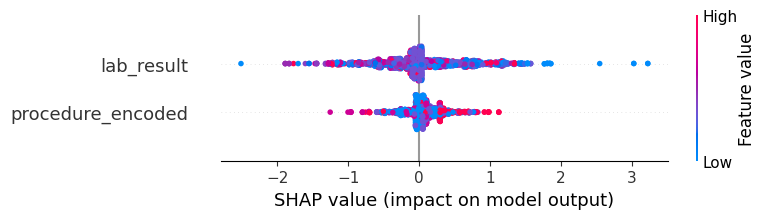

In [31]:
!pip install shap
import shap
import numpy as np

explainer = shap.TreeExplainer(model, X_test)
shap_values = explainer.shap_values(X_test)

# SHAP summary plot
shap.summary_plot(shap_values, X_test)


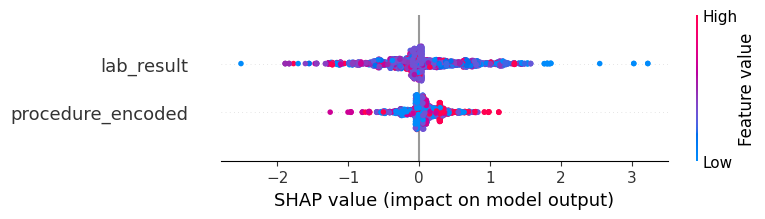

             feature  mean_abs_shap
0         lab_result       0.420614
1  procedure_encoded       0.191278


In [39]:
if isinstance(shap_values, list):
    shap_vals = shap_values[1]          # positive class
elif isinstance(shap_values, np.ndarray):
    shap_vals = shap_values
else:
    shap_vals = shap_values.values
shap.summary_plot(shap_vals, X_test)
shap_importance = np.abs(shap_vals).mean(axis=0)

shap_importance_df = (
    pd.DataFrame({
        "feature": X_test.columns,
        "mean_abs_shap": shap_importance
    })
    .sort_values(by="mean_abs_shap", ascending=False)
)

print(shap_importance_df.head(10))

In [41]:
shap_corr = {
    col: np.corrcoef(X_test[col], shap_vals[:, i])[0, 1]
    for i, col in enumerate(X_test.columns)
}

shap_correlation_df = (
    pd.DataFrame({
        "feature": shap_corr.keys(),
        "shap_correlation": shap_corr.values()
    })
    .sort_values(by="shap_correlation", ascending=False)
)

print(shap_correlation_df.head(10))

             feature  shap_correlation
1  procedure_encoded          0.284740
0         lab_result         -0.076125


In [46]:
# Probability predictions
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Use recall-focused threshold (same as before)
threshold = 0.30
y_pred = (y_pred_prob >= threshold).astype(int)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)


[[   1  269]
 [   1 1529]]


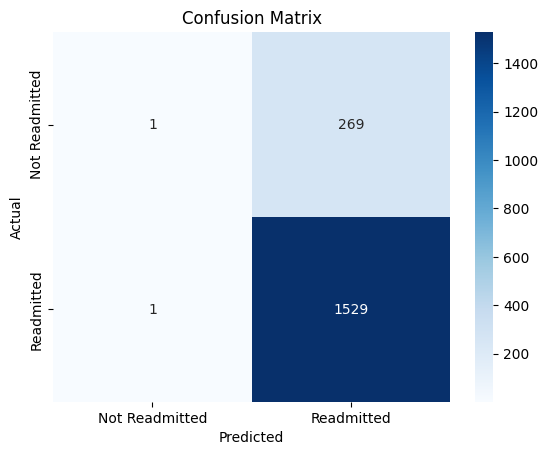

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not Readmitted", "Readmitted"],
    yticklabels=["Not Readmitted", "Readmitted"]
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [48]:
tn, fp, fn, tp = cm.ravel()
print(f"Recall = {tp / (tp + fn):.3f}")
print(f"Precision = {tp / (tp + fp):.3f}")


Recall = 0.999
Precision = 0.850


### Other potential models for this binary classification task include:

*   **Logistic Regression**: Simple, interpretable, and a good baseline.
*   **Gradient Boosting Machines (e.g., XGBoost, LightGBM)**: Often provide higher performance due to their boosting mechanism.
*   **Support Vector Machines (SVM)**: Can be effective, especially with different kernel functions.



## Google Colab is available in VS Code!
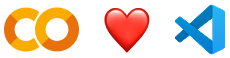

Try the new <a href="https://marketplace.visualstudio.com/items?itemName=Google.colab">Google Colab extension</a> for Visual Studio Code. You can get up and running in just a few clicks:

*  In VS Code, open the <strong><em>Extensions</em></strong> view and search for 'Google Colab' to install.
*  Open the kernel selector by creating or opening any <code>.ipynb</code> notebook file in your local workspace and either running a cell or clicking the <strong><em>Select kernel</em></strong> button in the top right.
*  Click <strong><em>Colab</em></strong> and then select your desired runtime, sign in with your Google Account and you're all set!

See more details in our <a href="https://developers.googleblog.com/google-colab-is-coming-to-vs-code">announcement blog here</a>.

## 🎁 Free-of-charge Pro plan for Gemini and Colab for US university students 🎓

Get more access to our most accurate model Gemini 3 Pro for advanced coding, complex research and innovative projects, backed by Colab's dedicated high-compute resources for data science and machine learning.

Get the Gemini free-of-charge offer at <a href="https://gemini.google/students?utm_source=colab&amp;utm_medium=banner&amp;utm_campaign=students_xpa_us-colab-banner">gemini.google/students</a>.  
Get the Colab free-of-charge offer at <a href="https://colab.research.google.com/signup">colab.research.google.com/signup</a>.  
Terms apply.

## Access popular AI models via Google Colab-AI without an API key
All users have access to most popular LLMs via the <code>google-colab-ai</code> Python library, and paid users have access to a wider selection of models. For more details, refer to <a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Getting_started_with_google_colab_ai.ipynb">getting started with Google Colab AI</a>.



In [32]:
from google.colab import ai
response = ai.generate_text("What is the capital of France?")
print(response)

The capital of France is **Paris**.


## Explore the Gemini API
The Gemini API gives you access to Gemini models created by Google DeepMind. Gemini models are built from the ground up to be multimodal, so you can reason seamlessly across text, images, code and audio.

**How to get started**
*  Go to <a href="https://aistudio.google.com/">Google AI Studio</a> and log in with your Google Account.
*  <a href="https://aistudio.google.com/app/apikey">Create an API key</a>.
* Use a quickstart for <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started.ipynb">Python</a> or call the REST API using <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/rest/Prompting_REST.ipynb">curl</a>.

**Discover Gemini's advanced capabilities**
*  Play with Gemini <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Image-out.ipynb">multimodal outputs</a>, mixing text and images in an iterative way.
*  Discover the <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started_LiveAPI.ipynb">multimodal Live API</a> &#40;demo <a href="https://aistudio.google.com/live">here</a>&#41;.
*  Learn how to <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Spatial_understanding.ipynb&quot;">analyse images and detect items in your pictures</a> using Gemini &#40;bonus, there's a <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Spatial_understanding_3d.ipynb">3D version</a> as well!&#41;.
*  Unlock the power of the <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started_thinking.ipynb">Gemini thinking model</a>, capable of solving complex tasks with its inner thoughts.
      
**Explore complex use cases**
*  Use <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Search_grounding_for_research_report.ipynb">Gemini grounding capabilities</a> to create a report on a company based on what the model can find on the Internet.
*  Extract <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Pdf_structured_outputs_on_invoices_and_forms.ipynb">invoices and form data from PDFs</a> in a structured way.
*  Create <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Book_illustration.ipynb">illustrations based on a whole book</a> using Gemini large context window and Imagen.

To learn more, take a look at the <a href="https://github.com/google-gemini/cookbook">Gemini cookbook</a> or visit the <a href="https://ai.google.dev/docs/">Gemini API documentation</a>.


Colab now has AI features powered by <a href="https://gemini.google.com">Gemini</a>. The video below provides information on how to use these features, whether you're new to Python or a seasoned veteran.

<center>
  <a href="https://www.youtube.com/watch?v=V7RXyqFUR98" target="_blank">
  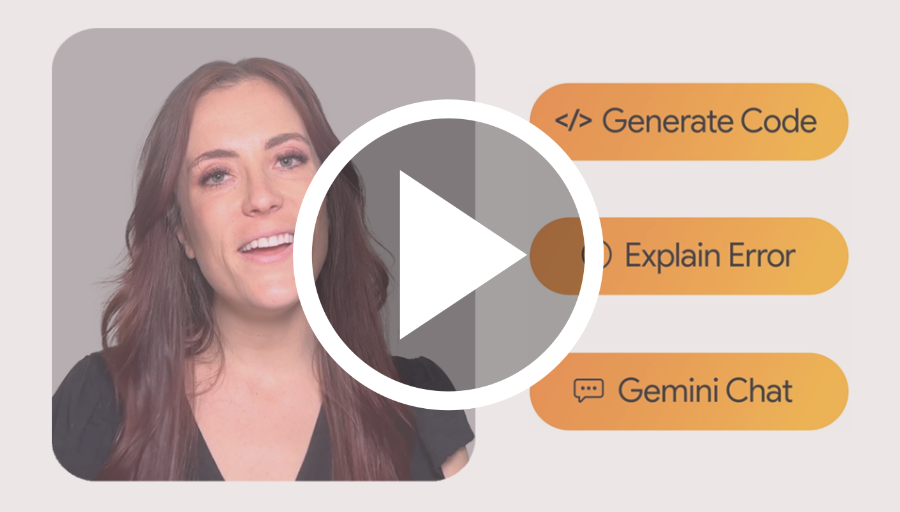
  </a>
</center>

<div class="markdown-google-sans">
  <h2>What is Colab?</h2>
</div>

Colab, or ‘Colaboratory’, allows you to write and execute Python in your browser, with
- Zero configuration required
- Access to GPUs free of charge
- Easy sharing

Whether you're a <strong>student</strong>, a <strong>data scientist</strong> or an <strong>AI researcher</strong>, Colab can make your work easier. Watch <a href="https://www.youtube.com/watch?v=inN8seMm7UI">Introduction to Colab</a> or <a href="https://www.youtube.com/watch?v=rNgswRZ2C1Y">Colab features you may have missed</a> to learn more or just get started below!

<div class="markdown-google-sans">

## <strong>Getting started</strong>
</div>

The document that you are reading is not a static web page, but an interactive environment called a <strong>Colab notebook</strong> that lets you write and execute code.

For example, here is a <strong>code cell</strong> with a short Python script that computes a value, stores it in a variable and prints the result:

In [33]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

To execute the code in the above cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut 'Command/Ctrl+Enter'. To edit the code, just click the cell and start editing.

Variables that you define in one cell can later be used in other cells:

In [34]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

Colab notebooks allow you to combine <strong>executable code</strong> and <strong>rich text</strong> in a single document, along with <strong>images</strong>, <strong>HTML</strong>, <strong>LaTeX</strong> and more. When you create your own Colab notebooks, they are stored in your Google Drive account. You can easily share your Colab notebooks with co-workers or friends, allowing them to comment on your notebooks or even edit them. To find out more, see <a href="/notebooks/basic_features_overview.ipynb">Overview of Colab</a>. To create a new Colab notebook you can use the File menu above, or use the following link: <a href="http://colab.research.google.com#create=true">Create a new Colab notebook</a>.

Colab notebooks are Jupyter notebooks that are hosted by Colab. To find out more about the Jupyter project, see <a href="https://www.jupyter.org">jupyter.org</a>.

<div class="markdown-google-sans">

## Data science
</div>

With Colab you can harness the full power of popular Python libraries to analyse and visualise data. The code cell below uses <strong>numpy</strong> to generate some random data, and uses <strong>matplotlib</strong> to visualise it. To edit the code, just click the cell and start editing.

You can import your own data into Colab notebooks from your Google Drive account, including from spreadsheets, as well as from GitHub and many other sources. To find out more about importing data, and how Colab can be used for data science, see the links below under <a href="#working-with-data">Working with data</a>.

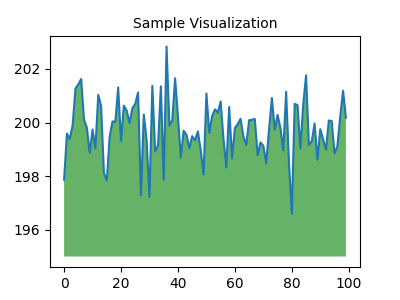

In [35]:
import numpy as np
import IPython.display as display
from matplotlib import pyplot as plt
import io
import base64

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

fig = plt.figure(figsize=(4, 3), facecolor='w')
plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)
plt.title("Sample Visualization", fontsize=10)

data = io.BytesIO()
plt.savefig(data)
image = F"data:image/png;base64,{base64.b64encode(data.getvalue()).decode()}"
alt = "Sample Visualization"
display.display(display.Markdown(F"""![{alt}]({image})"""))
plt.close(fig)

Colab notebooks execute code on Google's cloud servers, meaning that you can leverage the power of Google hardware, including <a href="#using-accelerated-hardware">GPUs and TPUs</a>, regardless of the power of your machine. All you need is a browser.

For example, if you find yourself waiting for <strong>pandas</strong> code to finish running and want to go faster, you can switch to a GPU runtime and use libraries like <a href="https://rapids.ai/cudf-pandas">RAPIDS cuDF</a> that provide zero-code-change acceleration.

To learn more about accelerating pandas on Colab, see the <a href="https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cudf_pandas_colab_demo.ipynb">10-minute guide</a> or
 <a href="https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cudf_pandas_stocks_demo.ipynb">US stock market data analysis demo</a>.

<div class="markdown-google-sans">

## Machine learning
</div>

With Colab you can import an image dataset, train an image classifier on it and evaluate the model, all in just <a href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb">a few lines of code</a>.

Colab is used extensively in the machine learning community with applications including:
- Getting started with TensorFlow
- Developing and training neural networks
- Experimenting with TPUs
- Disseminating AI research
- Creating tutorials

To see sample Colab notebooks that demonstrate machine learning applications, see the <a href="#machine-learning-examples">machine learning examples</a> below.

<div class="markdown-google-sans">

## More resources

### Working with notebooks in Colab

</div>

- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<div class="markdown-google-sans">

<a name="working-with-data"></a>
### Working with data
</div>

- [Loading data: Drive, Sheets and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualising data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

<div class="markdown-google-sans">

### Machine learning

<div>

These are a few of the notebooks related to machine learning, including Google's online machine learning course. See the <a href="https://developers.google.com/machine-learning/crash-course/">full course website</a> for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Intro to RAPIDS cuDF to accelerate pandas](https://nvda.ws/rapids-cudf)
- [Getting started with cuML's accelerator mode](https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cuml_sklearn_colab_demo.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)

<div class="markdown-google-sans">

<a name="using-accelerated-hardware"></a>
### Using accelerated hardware
</div>

- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TPUs in Colab](/notebooks/tpu.ipynb)

<div class="markdown-google-sans">

<a name="machine-learning-examples"></a>

### Featured examples

</div>

- <a href="https://tensorflow.org/hub/tutorials/tf2_image_retraining">Retraining an Image Classifier</a>: Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- <a href="https://tensorflow.org/hub/tutorials/tf2_text_classification">Text Classification</a>: Classify IMDB film reviews as either <em>positive</em> or <em>negative</em>.
- <a href="https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization">Style Transfer</a>: Use deep learning to transfer style between images.
- <a href="https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa">Multilingual Universal Sentence Encoder Q&amp;A</a>: Use a machine-learning model to answer questions from the SQuAD dataset.
- <a href="https://tensorflow.org/hub/tutorials/tweening_conv3d">Video Interpolation</a>: Predict what happened in a video between the first and the last frame.
